In [ ]:
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch    
from torch import nn
import numpy as np
import pandas as pd

from lightning.pytorch import seed_everything
from torch import set_float32_matmul_precision

seed_everything(42, workers=True)
set_float32_matmul_precision("medium")

from physioex.train.models import load_model
from physioex.train.networks import config as net_config 
from physioex.data import PhysioExDataModule

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import sys 
sys.path.append( os.getcwd() + "/../" )
from src.sleep.test_mixed import evaluate_model, get_importances
from src.sleep.train import TinyTransformerNet
from src.posthoc.sgradients import SpectralGradients


Seed set to 42


In [3]:
dataset = "sleepedf"
net = "tinytransformer"

device = "cuda" if torch.cuda.is_available() else "cpu"

basedir = f"../output/model/{net}/{dataset}/"

if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(f"Creating directory {basedir}")

ckpt_path = f"{basedir}checkpoint.ckpt"

100%|██████████| 103/103 [00:10<00:00, 10.09it/s]


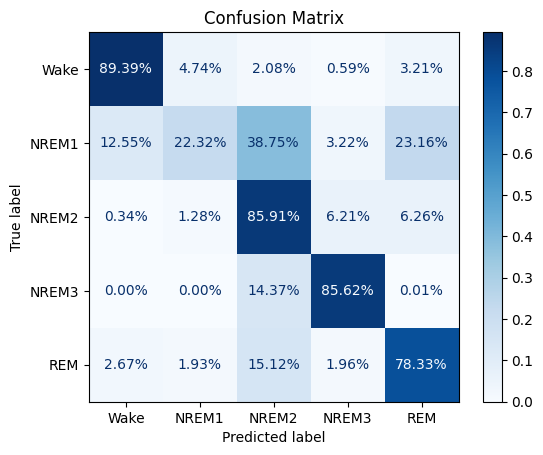

              precision    recall  f1-score        support
Wake           0.933339  0.893876  0.913181  161490.000000
NREM1          0.521623  0.223231  0.312659   58464.000000
NREM2          0.803172  0.859106  0.830198  208887.000000
NREM3          0.637860  0.856197  0.731075   35931.000000
REM            0.676183  0.783296  0.725809   84756.000000
accuracy       0.789791  0.789791  0.789791       0.789791
macro avg      0.714435  0.723141  0.702584  549528.000000
weighted avg   0.781075  0.789791  0.776942  549528.000000


(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [6]:
model_kwargs = {
    "n_classes": 5,
    "sf" : 100,
    "in_channels": 1,
    "sequence_length" : 21,

    "loss" : "physioex.train.networks.utils.loss:CrossEntropyLoss",
    "loss_kwargs": {},

    "learning_rate" : .0001,
    "weight_decay" :  .000001,
}

model = TinyTransformerNet.load_from_checkpoint( ckpt_path, config = model_kwargs ).eval()
# add a softmax layer to the model

class Wrapper( torch.nn.Module ):
    def __init__( self, model ):
        super(Wrapper, self).__init__()
        
        self.model = torch.nn.Sequential(
            model,
            torch.nn.Softmax(dim=-1)
        )    
    def forward( self, x ):
        return self.model( x )[..., :-1]

model = Wrapper( model = model)


datamodule = PhysioExDataModule(
        datasets = [dataset],
        batch_size = 256,
        data_folder = os.environ["PHYSIOEXDATA"],
        num_workers = os.cpu_count(),
)

test_loader = datamodule.test_dataloader()

evaluate_model( model, test_loader, basedir)

In [7]:
# get the importances "x", the stages "y" and the predictions "y_hat"
x_train, y_train, y_hat_train, x_val, y_val, y_hat_val, x_test, y_test, y_hat_test = get_importances( model, datamodule, basedir)

# now we need to get the signals
signal_train, signal_val, signal_test = [], [], []
for batch in tqdm( datamodule.train_dataloader() ):
    x, _ = batch
    x = x.cpu().numpy()
    signal_train.append(x)
for batch in tqdm( datamodule.val_dataloader() ):
    x, _ = batch
    x = x.cpu().numpy()
    signal_val.append(x)
for batch in tqdm( datamodule.test_dataloader() ):
    x, _ = batch
    x = x.cpu().numpy()
    signal_test.append(x)
    
signal_train = np.concatenate(signal_train, axis=0)
signal_val = np.concatenate(signal_val, axis=0)
signal_test = np.concatenate(signal_test, axis=0)

print("Signal shape: ", signal_train.shape, signal_val.shape, signal_test.shape)

# reshape the importances accordingly to the signals
x_train = x_train.reshape( *signal_train.shape[:2], 6)
x_val = x_val.reshape( *signal_val.shape[:2], 6, 5)
x_test = x_test.reshape( *signal_test.shape[:2], 6, 5)

print( "Importances shape : ", x_train.shape, x_val.shape, x_test.shape)

2025-04-15 16:45:31.191 | INFO     | src.sleep.test_mixed:get_importances:59 - Extracting bands importance from training set ...
100%|██████████| 509/509 [15:08<00:00,  1.78s/it]


importances shape:  (2736006, 6, 5)
y_true shape:  (2736006,)
y_hats shape:  (2736006, 5)
x_train shape:  (2736006, 6, 5)
y_train shape:  (2736006,)
y_hat_train shape:  (2736006, 5)


2025-04-15 17:00:44.670 | INFO     | src.sleep.test_mixed:get_importances:87 - Extracting bands importance from validation set ...
100%|██████████| 143/143 [04:17<00:00,  1.80s/it]


importances shape:  (765030, 6, 5)
y_true shape:  (765030,)
y_hats shape:  (765030, 5)


2025-04-15 17:05:03.127 | INFO     | src.sleep.test_mixed:get_importances:106 - Extracting bands importance from test set ...
100%|██████████| 103/103 [03:02<00:00,  1.77s/it]


importances shape:  (549528, 6, 5)
y_true shape:  (549528,)
y_hats shape:  (549528, 5)


100%|██████████| 103/103 [00:01<00:00, 80.93it/s]


Signal shape:  (130286, 21, 1, 3000) (36430, 21, 1, 3000) (26168, 21, 1, 3000)
Importances shape :  (130286, 21, 6) (36430, 21, 6, 5) (26168, 21, 6, 5)


In [9]:
class ExWrapper(torch.nn.Module):
    def __init__(
        self,
        func: torch.nn.Module,
        index = None,
        target = None,
    ):
        super().__init__()
        self.model = func
        self.target = target
        self.index = index

    def forward(self, x):
        if len( x.shape ) > 1:
            batch_size = x.shape[0]
            batched = True
        else:
            batched = False
            batch_size = 1
            
        x = x.reshape(batch_size, 21, 1, 3000)

        x = self.model(x)

        if self.index is not None and self.target is not None:
            x = x[:, self.index, self.target]
        elif self.index is not None:
            x = x[:, self.index]
        elif self.target is not None:
            x = x[:, :, self.target]    
        else:
            pass

        if batched:
            x = x.reshape(batch_size, -1)
        else:
            x = x.reshape(-1)
            
        return x

In [10]:
# shape signals: num_samples, seq_len (21), num_channels (1), num_timestamps (3000)
# shape importances: num_samples, seq_len (21), num_bands (6), num_classes (5)

# let's see if we can identify sleep spindles ( sigma band ) into correctly predicted NREM2 epochs
# get the indices of the correctly predicted NREM2 epochs

nrem2 = signal_test.reshape(-1, 3000)
importances = x_test.reshape(-1, 6, 5)[..., 2]

indexes = np.arange( nrem2.shape[0] )

nrem2_preds = np.argmax(y_hat_test.reshape(-1, 5), axis=-1)
nrem2_labels = y_test.reshape(-1)

true_positive = np.where((nrem2_labels == 2) & (nrem2_preds == 2))[0]

# select the true_positive epochs
nrem2 = nrem2[true_positive]
importances = importances[true_positive]
nrem2_preds = y_hat_test.reshape(-1, 5)[true_positive]
indexes = indexes[true_positive]

# get the elements for which the sigma band (2) is the most important band
sigma = np.argmax(importances, axis=-1) == 2
if sigma.sum() == 0:
    print("No epochs found with sigma band as most important band")
else:
    nrem2 = nrem2[sigma]
    importances = importances[sigma]
    true_positive = true_positive[sigma]  # Update true_positive to match filtered epochs
    indexes = indexes[sigma]  
    print("Number of epochs with sigma band as most important band: ", nrem2.shape[0])

idx = 0

# we need to locate the sequence in which the 'idx' epoch is located
index = indexes[idx]
sequence_indx = index  // 21
epoch_indx = index % 21
print("Epoch index: ", epoch_indx, "Sequence index: ", sequence_indx)

exmodel = ExWrapper(
    func = model,
    index = epoch_indx,
    target = 2
).to( device )

SG = SpectralGradients(
    f = exmodel,
    fs = 100,
    Q = 5,
    nperseg = 200,
    strategy = "highest",
    n_points = 2,
).to(device)

signal = torch.tensor(signal_test[sequence_indx], dtype=torch.float32)
signal = signal.reshape( 1, -1 ).to(device)

w, sg = SG( signal )

signal = signal.cpu().numpy()

sg = sg.cpu().numpy()
w = w.detach().cpu().numpy()

signal = signal.reshape( 21, 3000 )
w = w.reshape( 100 )
sg = sg.reshape( 100, 21, 3000)
sg = np.transpose(sg, (1, 0, 2))

print("Signal shape: ", signal.shape, "SG shape: ", sg.shape, "w shape: ", w.shape)


Number of epochs with sigma band as most important band:  121
Epoch index:  0 Sequence index:  2123


/esat/biomeddata/ggagliar/miniconda3/envs/specgrad/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_efficient_attention_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Signal shape:  (21, 3000) SG shape:  (21, 100, 3000) w shape:  (100,)


NREM2 confidence :  0.68044764
NREM2 importances :  [0.02518678 0.20555842 0.23096284 0.18113266 0.17618915 0.02821744]


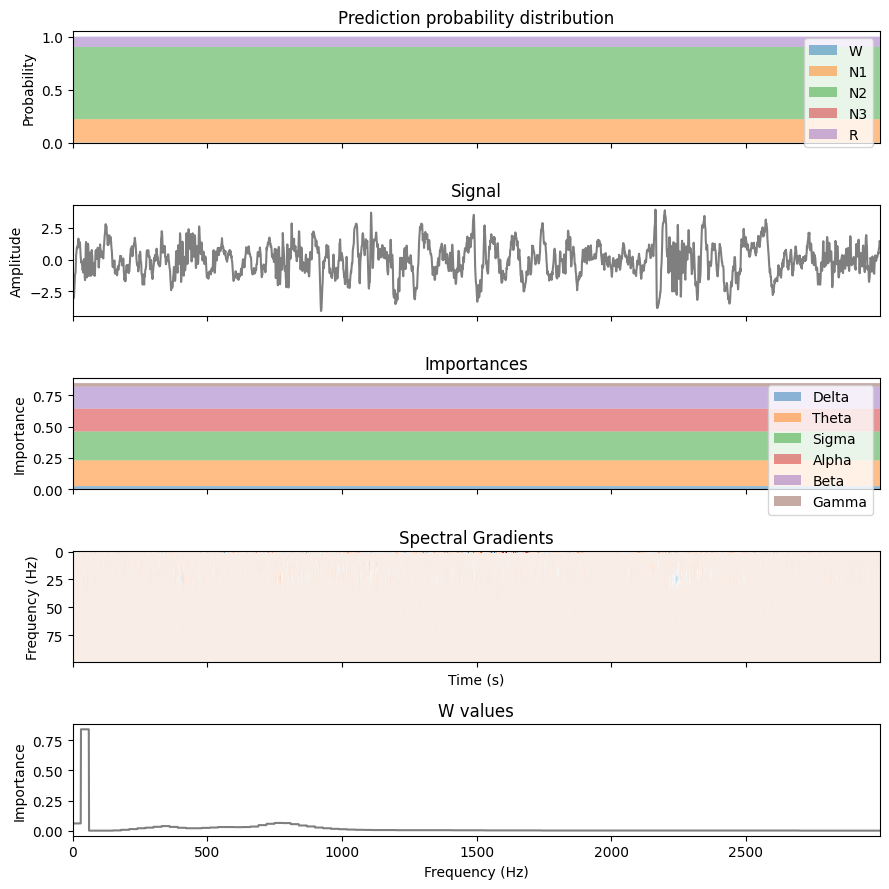

In [11]:
# Plot the sequence of 21 epochs

print( "NREM2 confidence : ", nrem2_preds[idx][2] )
print( "NREM2 importances : ", importances[idx] )

fig, axs = plt.subplots(5, 1, figsize=(9, 9), sharex=True)

# Plot the prediction probability distribution for the sequence
axs[0].set_title("Prediction probability distribution")
axs[0].set_ylabel("Probability")

target_proba = nrem2_preds[idx].repeat( 3000 ).reshape(5, 3000)

axs[0].stackplot(
    range(0, 3000),
    target_proba,
    labels=["W", "N1", "N2", "N3", "R"],
    alpha=0.5,
)
axs[0].legend(loc="upper right")

axs[1].set_title("Signal")
axs[1].set_ylabel("Amplitude")
axs[1].plot(
    range(0, 3000),
    signal[epoch_indx].squeeze(),
    color="black",
    alpha=0.5,
)

# Plot the importances for the sequence
axs[2].set_title("Importances")
axs[2].set_ylabel("Importance")

importance_proba = importances[idx].repeat(3000).reshape(6, 3000)
axs[2].stackplot(
    range(0, 3000),
    importance_proba,
    labels=["Delta", "Theta", "Sigma", "Alpha", "Beta", "Gamma"],
    alpha=0.5,
)
axs[2].legend(loc="upper right")

# Plot the spectral gradients for the epoch
axs[3].set_title("Spectral Gradients")
axs[3].set_ylabel("Frequency (Hz)")
axs[3].set_xlabel("Time (s)")

sg_epoch = sg[epoch_indx] # shape is (100, 3000) 100 frequencies with .5 Hz resolution
# plot it as a heatmap
im = axs[3].imshow(
    sg_epoch,
    aspect="auto",
    interpolation="nearest",
    cmap="RdBu",
)

# plot the W values, W is the importance of the frequencies ( 100 values )
# plot it as a line plot so --> 3000
plot_w = w.reshape(100, 1).repeat(30, axis=1).reshape(3000)

axs[4].set_title("W values")
axs[4].set_ylabel("Importance")
axs[4].set_xlabel("Frequency (Hz)")
axs[4].plot(
    range(0, 3000),
    plot_w,
    color="black",
    alpha=0.5,
)

plt.tight_layout()
plt.show()
